In [1]:
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Input, TimeDistributed, Bidirectional
from keras.losses import Huber, MeanSquaredError
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
plt.style.use('fivethirtyeight')

In [ ]:
#IHSG
stock_code = 'IHSG'
startdate = '2016-04-12'
enddate = '2021-04-12'
df = web.DataReader(f'^JKSE', data_source='yahoo', start = startdate, end = enddate)

In [57]:
#Ambil Data Saham
stock_code = 'INCO'
#startdate = str((date.today()-timedelta(days = 365))) 
startdate = str((date.today()-relativedelta(years=5))) #Untuk ambil n tahun kebelakang dapat menggunakan relativedelta
enddate = str(date.today())
df = web.DataReader(f'{stock_code}.JK', data_source='yahoo', start = startdate, end = enddate)

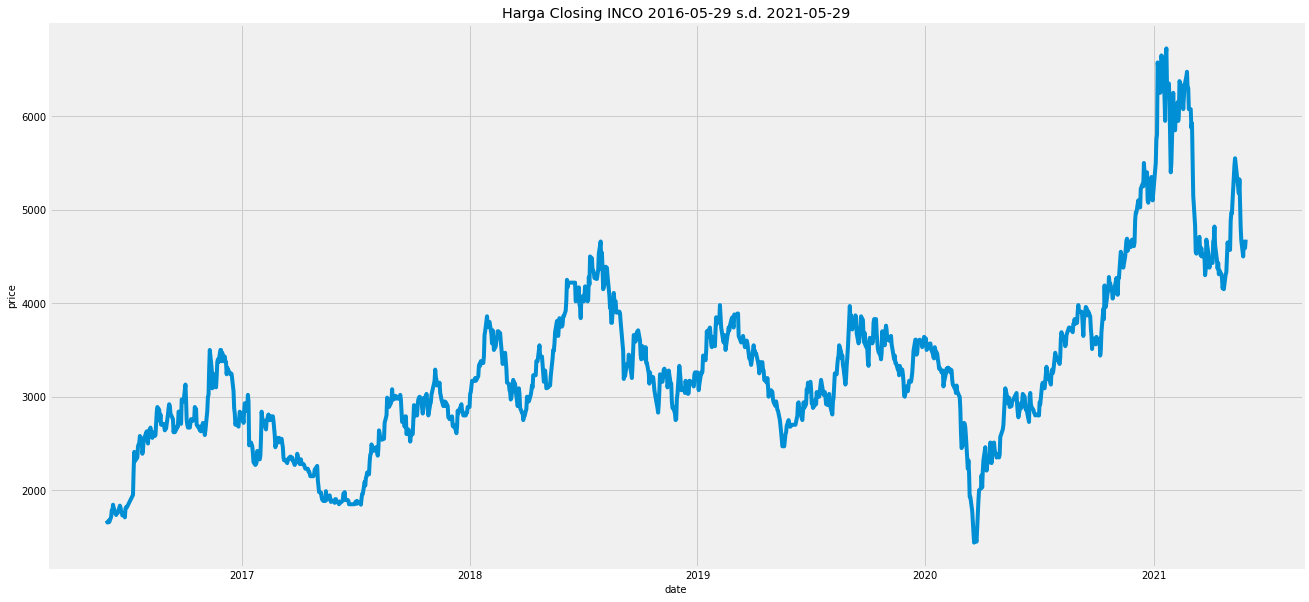

In [58]:
plt.figure(figsize=(20,10))
plt.title(f'Harga Closing {stock_code} {startdate} s.d. {enddate}')
#plt.plot(df['Open'])
plt.plot(df['Close'])
plt.xlabel('date', fontsize = 10)
plt.ylabel('price', fontsize = 10)
plt.show()

In [59]:
#Ambil harga penutupan dari saham
data = df.filter(['Close'])
data["log_returns"] = np.log(1 + data['Close'].pct_change())
data.dropna(inplace=True)
dataset = data.values
data_len = len(dataset)
n_feature = dataset.shape[1]
print(data_len)

1257


In [ ]:
dataset

In [ ]:
#embedding = LocallyLinearEmbedding(n_components=1)
#embedded_data = embedding.fit_transform(dataset)
#embedded_data.shape

In [60]:
#Apply MinMaxScaler / Normalisasi
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [6]:
h = 360 #Jumlah test
inp = 14 #Besar input

In [61]:
data.iloc[0:data_len-h-inp,:]

,Close,log_returns
Date,,
2016-05-31,1655.0,-0.012012
2016-06-01,1655.0,0.000000
2016-06-02,1675.0,0.012012
2016-06-03,1660.0,-0.008996
2016-06-06,1715.0,0.032595
...,...,...
2019-11-04,3600.0,-0.002774
2019-11-05,3640.0,0.011050
2019-11-06,3610.0,-0.008276


In [62]:
data.iloc[data_len-(inp+h):data_len,:]

,Close,log_returns
Date,,
2019-11-11,3440.0,-0.034289
2019-11-12,3400.0,-0.011696
2019-11-13,3440.0,0.011696
2019-11-14,3360.0,-0.023530
2019-11-15,3360.0,0.000000
...,...,...
2021-05-21,4670.0,-0.029538
2021-05-24,4500.0,-0.037082
2021-05-25,4650.0,0.032790


In [63]:
train_data = scaled_data[0:data_len-h-inp,:] 
x_train = []
y_train = []
for i in range(inp, len(train_data)): 
  x_train.append(train_data[i-inp:i, :])
  y_train.append(train_data[i, :])
  #if i<=60:
  #  print(x_train)
  #  print(y_train)

In [64]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [65]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_feature)) 

In [66]:
learning_rate = 0.01
epoch=10

#model = Sequential()
input_model = Input(shape=(inp, n_feature))
lstm_model1 = Bidirectional(LSTM(50, return_sequences=False, activation='tanh'), merge_mode = 'concat', input_shape=(x_train.shape[1], n_feature))
#lstm_model1 = LSTM(100, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], n_feature))
output1 = lstm_model1(input_model)
#lstm_model2 = LSTM(100, return_sequences=False)
#output2 = lstm_model2(output1)
dropout_layer = Dropout(0.4)
output3 = dropout_layer(output1)
dense_layer1 = Dense(inp)
output4 = dense_layer1(output3)
dense_layer2 = Dense(2)
output_final = dense_layer2(output4)
model = Model(input_model,output_final)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 2)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 100)           21200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1414      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 30        
Total params: 103,044
Trainable params: 103,044
Non-trainable params: 0
_____________________________________________________

In [ ]:
#model = load_model('StockPriceLSTMmodel.h5')

In [67]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss = [Huber(), MeanSquaredError()])
model.fit(x_train, y_train, batch_size=10, epochs=epoch)

Epoch 1/10
87/87 [==============================] - 5s 9ms/step - loss: 0.0150
Epoch 2/10
87/87 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 3/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 4/10
87/87 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 5/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 6/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 7/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 8/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 9/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 10/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0022


In [ ]:
#model.save('StockPriceLSTMmodel.h5')

In [68]:
test_data = scaled_data[data_len-(inp+h):data_len,:]
x_test = []
y_test = []
for i in range(inp, len(test_data)):
  x_test.append(test_data[i-inp:i, :])
  y_test.append(test_data[i, :])

In [69]:
x_test,y_test = np.array(x_test), np.array(y_test)

In [70]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_feature))

In [71]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test[:,0], predictions[:,0]))
print('MAE: ', mean_absolute_error(y_test[:,0], predictions[:,0]))
print('MSE: ', mean_squared_error(y_test[:,0], predictions[:,0],squared=True))
print('rmse: ',mean_squared_error(y_test[:,0], predictions[:,0],squared=False))
predictions = scaler.inverse_transform(predictions)
#predictions[:,0]

r2_score:  0.9771149861597861
MAE:  0.024798295473759988
MSE:  0.0011363971881651574
rmse:  0.03371049077312814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


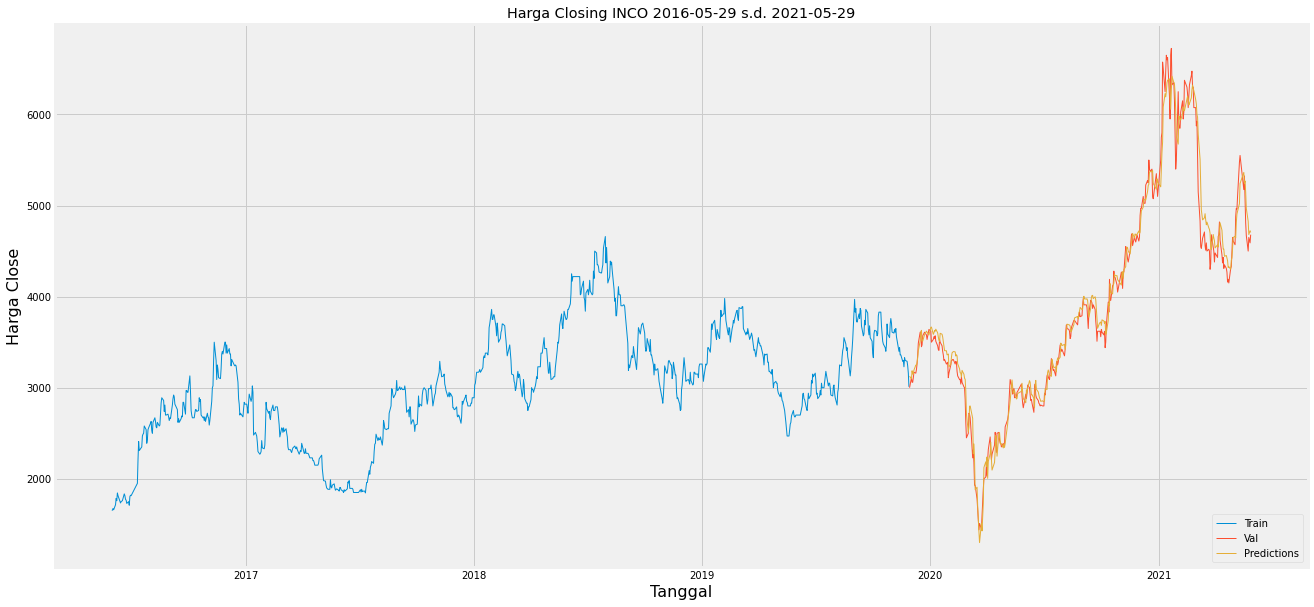

In [72]:
train = data[:data_len-h]
test = data[data_len-h:data_len]
test['Predictions'] = predictions[:,0]
plt.figure(figsize=(20,10))
plt.title(f'Harga Closing {stock_code} {startdate} s.d. {enddate}')
plt.xlabel('Tanggal', fontsize = 16 )
plt.ylabel('Harga Close', fontsize = 16 )
plt.plot(train['Close'],linewidth=1)
plt.plot(test[['Close','Predictions']],linewidth=1)
#x = pd.to_datetime('2018/02/01', format='%Y/%m/%d')
#str1 = 'Learning rate: {}'.format(learning_rate)
#str2 = 'Epoch: {}'.format(epoch)
#plt.annotate(str1, (x,4200), (x,4200), fontsize=12)
#plt.annotate(str2, (x,4100), (x,4100), fontsize=12)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

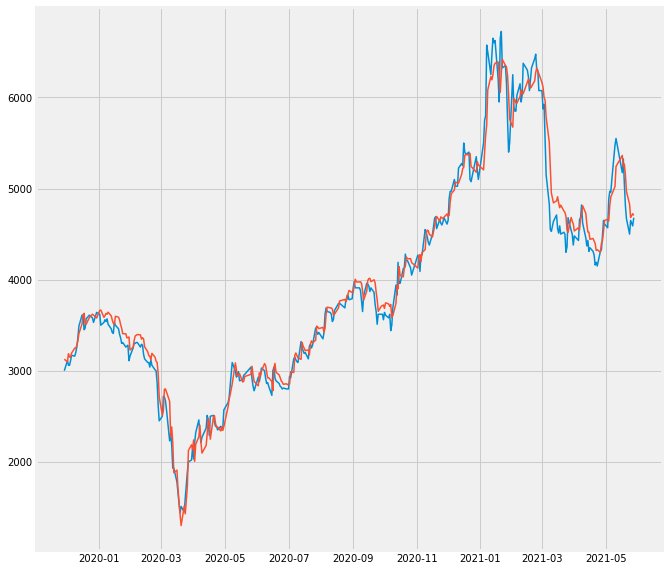

In [73]:
plt.figure(figsize=(10,10))
plt.plot(test[['Close','Predictions']],linewidth=1.5)

Prediksi Untuk Hari-hari Kedepan

In [35]:
inp

14

In [74]:
hari = int(input("Jumlah hari: "))
data_pred = scaled_data[data_len-inp:data_len,:]
for i in range(0,hari):
  x_pred = np.vstack(data_pred[i:i+inp, :])
  x_pred = np.array(x_pred)
  x_pred = np.reshape(x_pred, (1, x_pred.shape[0], n_feature))
  predict = model.predict(x_pred)
  data_pred = np.vstack((data_pred, predict))

Jumlah hari: 30


[4770.91082036 4824.22667056 4876.4475441  4925.4808259  4970.55064499
 5005.21913081 5017.24969864 5033.84224921 5036.96085364 5038.32421929
 5042.84399062 5044.54630762 5056.13712072 5064.70351756 5081.68290108
 5096.63582176 5112.98612922 5129.97716814 5146.91528529 5163.12635809
 5178.27080518 5192.65324175 5205.92054099 5218.48032653 5230.52191973
 5242.15431422 5253.69882077 5265.054636   5276.47061825 5287.76626647]


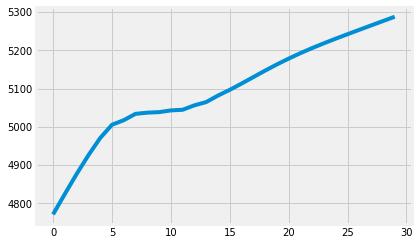

In [75]:
hasil_prediksi = data_pred[len(data_pred)-hari:len(data_pred),:]
hasil_prediksi = scaler.inverse_transform(hasil_prediksi)
print(hasil_prediksi[:,0]) #Hasil prediksi
plt.plot(hasil_prediksi[:,0])